In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
#from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

C:\Users\Abhinav\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tqdm import tqdm

In [3]:
token = 'Flickr8k_text/Flickr8k.token.txt'


In [4]:
captions = open(token, 'r').read().strip().split('\n')
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [5]:
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
print(row[0])


997722733_0cb5439472.jpg


In [6]:

d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]
d        

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

In [7]:
d['1003163366_44323f5815.jpg']

['A man lays on a bench while his dog sits by him .',
 'A man lays on the bench to which a white dog is also tied .',
 'a man sleeping on a bench outside with a white and black dog sitting next to him .',
 'A shirtless man lies on a park bench with his dog .',
 'man laying on bench holding leash of dog sitting on ground']

In [8]:
images = 'Flicker8k_Dataset/'


In [9]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [10]:
img[:5]

['Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [11]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'


In [12]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
print(train_images)                  

{'2092870249_90e3f1855b.jpg', '3587781729_bd21ce7b11.jpg', '3251234434_d01e25a50a.jpg', '1835511273_790eaae6e6.jpg', '2354456107_bf5c766a05.jpg', '3122497129_d08f5729b8.jpg', '2436160351_108924a65b.jpg', '3680218298_582e6a2289.jpg', '217583047_5e93e1e119.jpg', '2695085448_a11833df95.jpg', '3717845800_ab45e255b8.jpg', '2271955077_0020b4ee0d.jpg', '1248734482_3038218f3b.jpg', '2871962580_b85ce502ba.jpg', '3643684688_2f7157b23d.jpg', '2466495935_623b144183.jpg', '2823200990_7b02b7cc36.jpg', '344841963_8b0fa9784c.jpg', '2403544744_cba152f5c1.jpg', '3649802021_8a689bc153.jpg', '399246804_b4b5dc70e1.jpg', '2687539673_d54a8dc613.jpg', '2704379125_9c35650d16.jpg', '2394267183_735d2dc868.jpg', '3621652774_fd9634bd5b.jpg', '2692635048_16c279ff9e.jpg', '3398745929_8cd3bbb8a8.jpg', '3431121650_056db85987.jpg', '2672445419_251ce9419a.jpg', '444872454_9f51e07f88.jpg', '3510695264_ef460fa6cc.jpg', '3632225464_612d7b4c0f.jpg', '2894229082_ddc395f138.jpg', '3174713468_e22fa7779e.jpg', '3511062827_cd878

In [13]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [14]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)


6000

In [15]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))
val_images

{'3019986034_7453777274.jpg',
 '2914800692_0c512d27b8.jpg',
 '3530502404_f8c3a3f61c.jpg',
 '2647229826_e0e0c65ef1.jpg',
 '3676460610_8c52e8a355.jpg',
 '3751594676_edfbfa0688.jpg',
 '2158267555_db1d94e468.jpg',
 '463786229_b54c9a3436.jpg',
 '3529314899_b4e533bb76.jpg',
 '410042380_517ccee020.jpg',
 '497122685_a51b29dc46.jpg',
 '2977379863_2e8d7a104e.jpg',
 '288508162_1727873924.jpg',
 '2286823363_7d554ea740.jpg',
 '3665179773_dd217416fc.jpg',
 '2081679622_6f1442367d.jpg',
 '2474092890_6c0781a8ed.jpg',
 '2598012140_832863fcb9.jpg',
 '210126070_0d43b300b9.jpg',
 '2480021389_dda9fb2818.jpg',
 '2100735137_05c6079537.jpg',
 '2092177624_13ab757e8b.jpg',
 '3287969199_08e775d896.jpg',
 '501699433_f8df386cf9.jpg',
 '745563422_f4fa7d9157.jpg',
 '225699652_53f6fb33cd.jpg',
 '3672944692_8d24a44fc6.jpg',
 '3226796100_08c49cfa5c.jpg',
 '2542415282_9240e1b5fc.jpg',
 '3225226381_9fe306fb9e.jpg',
 '3508522093_51f6d77f45.jpg',
 '2863027424_9c75105660.jpg',
 '3175434849_859f09fe07.jpg',
 '3440952969_608eb

In [16]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [17]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [18]:
# Getting the test images from all the images
test_img = split_data(test_images)
len(test_images)

1000

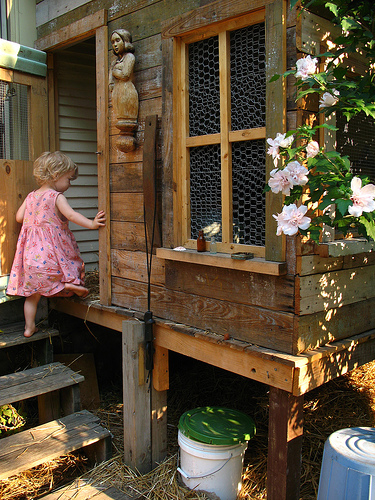

In [19]:
Image.open(train_img[0])

In [20]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [21]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


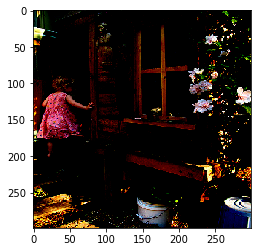

In [22]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [23]:
(preprocess(train_img[0])).shape

(1, 299, 299, 3)

In [24]:
np.squeeze(preprocess(train_img[0]))

array([[[-0.54509807, -0.56078434, -0.3960784 ],
        [-0.09803921,  0.02745104,  0.0196079 ],
        [-0.06666666,  0.05098045,  0.09019613],
        ...,
        [-0.9607843 , -0.9607843 , -0.9764706 ],
        [-0.96862745, -0.96862745, -0.9843137 ],
        [-0.9529412 , -0.9529412 , -0.96862745]],

       [[-0.5921569 , -0.6       , -0.4588235 ],
        [-0.09803921,  0.0196079 , -0.03529412],
        [-0.05882353,  0.07450986,  0.13725495],
        ...,
        [-0.96862745, -0.9764706 , -1.        ],
        [-0.94509804, -0.92941177, -0.9529412 ],
        [-0.9843137 , -0.96862745, -0.9764706 ]],

       [[-0.6156863 , -0.6392157 , -0.47450978],
        [-0.09019607,  0.02745104,  0.00392163],
        [-0.0745098 ,  0.05098045,  0.15294123],
        ...,
        [-0.9137255 , -0.9137255 , -0.92941177],
        [-0.8901961 , -0.7647059 , -0.9764706 ],
        [-0.78039217, -0.6       , -0.9607843 ]],

       ...,

       [[ 0.32549024, -0.5529412 , -0.94509804],
        [ 0

In [25]:
dpk = np.squeeze(preprocess(train_img[0])).shape
dpk

(299, 299, 3)

In [26]:
model = InceptionV3(weights='imagenet')

In [27]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [28]:
tryi = model_new.predict(preprocess(train_img[0]))


In [29]:
tryi.shape

(1, 2048)

In [30]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc


In [31]:

#encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]


NameError: name 'encoding_train' is not defined

In [32]:
with open('new_encoded_images_inceptionV3.p', 'rb') as b:
    encoding_train = pickle.load(b)

In [33]:
#with open("new_encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    #pickle.dump(encoding_train, encoded_pickle)

In [34]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [35]:
#encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


NameError: name 'encoding_test' is not defined

In [36]:
#with open("new_encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    #pickle.dump(encoding_test, encoded_pickle)

In [37]:
with open('new_encoded_images_test_inceptionV3.p', 'rb') as a:
    encoding_test = pickle.load(a)

In [38]:
#encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [39]:
encoding_test[test_img[0][len(images):]].shape


(2048,)

In [40]:

train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]


Calculating unique vocabulary

In [41]:

caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [42]:

words = [i.split() for i in caps]

In [43]:
words = [i.split() for i in caps]
unique = []
for i in words:
    unique.extend(i)

In [44]:

unique = list(set(unique))

In [45]:

unique = pickle.load(open('unique.p', 'rb'))

In [46]:

thefile = open('Inception_vocab.txt', 'w')
for item in unique:
  thefile.write(str(item) + "\n")
thefile.close() 

In [47]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [48]:
file_len('Inception_vocab.txt')

8256

Mapping unique words to indices

In [49]:


word2idx = {val:index for index, val in enumerate(unique)}

In [50]:
word2idx['<start>']


5553

In [51]:
idx2word = {index:val for index, val in enumerate(unique)}

In [52]:
idx2word[5553]

'<start>'

In [53]:

max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [54]:

vocab_size = len(unique)
vocab_size

8256

In [55]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [56]:

for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [57]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')


In [58]:

c = [i for i in df['captions']]
len(c)

30000

In [59]:
imgs = [i for i in df['image_id']]

In [60]:

a = c[10]
a, imgs[10]

('<start> A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . <end>',
 '1002674143_1b742ab4b8.jpg')

In [61]:

for i in a.split():
    print (i, "->", word2idx[i])

<start> -> 5553
A -> 4228
little -> 2694
girl -> 2482
covered -> 3168
in -> 8156
paint -> 1276
sits -> 6267
in -> 8156
front -> 522
of -> 3747
a -> 32
painted -> 7130
rainbow -> 6176
with -> 4350
her -> 7258
hands -> 3535
in -> 8156
a -> 32
bowl -> 1970
. -> 7023
<end> -> 5232


In [62]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1
samples_per_epoch    

383454

# Generator

In [63]:

def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

####################################   Model 1 ##################################################

In [ ]:
from keras.layers import Concatenate
from keras.layers import Activation, Dense
from keras.layers import Input, Dropout
from keras.layers import concatenate
from keras.layers import Add
embedding_size = 300


In [ ]:

# define the captioning model
def define_model(vocab_size, max_len,embedding_size = 300):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.2)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_len,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    se2 = Dropout(0.2)(se1)
    se3 = LSTM(256 , return_sequences= True)(se2)
    se4 = TimeDistributed(Dense(300))(se3)
    # decoder model
    decoder1 = Add()([fe2, se4])
    se4 = Dropout(0.2)(decoder1)
    se5 = LSTM(256, return_sequences= True)(se4)
    se6 = LSTM(256)(se5)
    decoder2 = Dense(256, activation='relu')(se6)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop',metrics=['accuracy'])
    # summarize model
    model.summary()
    
    return model



In [ ]:
ultimate_model_2 = define_model(8256,40)

In [ ]:
batch_size = 512

ultimate_model_2.fit_generator(data_generator(batch_size), samples_per_epoch=(samples_per_epoch/batch_size), epochs=15, 
                          verbose=1)

In [ ]:
ultimate_model_2.save_weights('GPU_model2_exp2_loss.h5')
from keras.models import load_model


ultimate_model_2.save('GPU_ultimate_model.h5')


In [ ]:


model_json = ultimate_model_2.to_json()
with open("GPU_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:

def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = ultimate_model_2.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:

try_image = test_img[22]
Image.open(try_image)

In [ ]:
print ('Normal search:', predict_captions(try_image))

In [ ]:
import keras
from keras import backend as K
import numpy as np
from keras.utils import np_utils
from Freeze_Graph_Script import freeze_graph
import tensorflow as tf


In [ ]:
# Sets the learning phase so that we don't have to enter a value for dropout in android
K.set_learning_phase(1)

In [ ]:
frozen_graph = freeze_graph(K.get_session(), output_names=[ultimate_model_2.output.op.name])
tf.train.write_graph(frozen_graph, '.', 'Icaption202.pb', as_text=False)

In [ ]:
print(ultimate_model_2.output.op.name)

In [ ]:
import tensorflow as tf
gf = tf.GraphDef()
gf.ParseFromString(open('.\\Icaption202.pb','rb').read())

In [ ]:
[n.name + '=>' +  n.op for n in gf.node if n.op in ( 'Softmax','Placeholder')]


####################################   Model 2 ##################################################

In [ ]:
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input
from keras.layers import Bidirectional , TimeDistributed
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add

# define the captioning model
def define_model_2(vocab_size, max_len,embedding_size = 300):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.2)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_len,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    se2 = Dropout(0.2)(se1)
    se3 = Bidirectional(LSTM(256,return_sequences=True))(se2)
    se4 = TimeDistributed(Dense(300))(se3)
    # decoder model
    main1 = Add()([fe2, se4])
    se4 = Dropout(0.2)(main1)
    BLSTM1 = Bidirectional(LSTM(256, return_sequences=True))(se4)
    print(BLSTM1.shape)
    BLSTM2 = Bidirectional(LSTM(256))(BLSTM1)
    decoder2 = Dense(256, activation='relu')(BLSTM2)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy',  optimizer='RMSprop',metrics=['accuracy'])
    # summarize model
    model.summary()
    
    return model

In [ ]:
trial_model = define_model_2(8256,40)

In [ ]:
#Keras-callbacks
#es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=, verbose=1)
#rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
#mcp = ModelCheckpoint(filepath='BEST_model1_exp1_loss.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

batch_size = 512
trial_model.fit_generator(data_generator(batch_size), steps_per_epoch=(samples_per_epoch/batch_size),epochs=15,verbose=1)

In [ ]:
trial_model.save_weights('GPU_blstm_model1_exp1_loss.h5')
from keras.models import load_model
trial_model_json_model = trial_model.to_json()

trial_model.save('GPU_blstm_trial_model.h5')



In [64]:
from keras.models import load_model
t_model = load_model('GPU_blstm_trial_model.h5')

In [65]:

def predict_captions_2(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = t_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

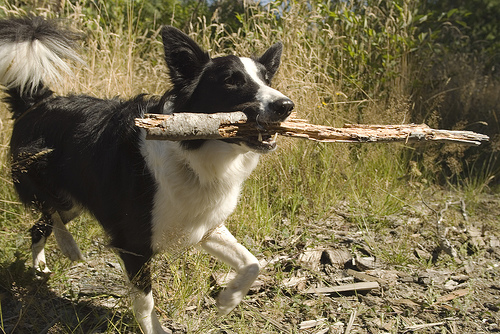

In [66]:

try_image = test_img[22]
Image.open(try_image)

In [67]:
print ('Normal search:', predict_captions_2(try_image))

Normal search: A dog runs through the grass .


In [ ]:

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
# step over the whole set
    for key, desc_list in descriptions.items():
# generate description
        yhat = predict_captions_2(photos[key])
# store actual and predicted
        references = [d3.split() for d3 in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
# calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
#art1 = test_img[int(np.random.randint(0, 1000, size=1))]
#print (art1)
#print ('Normal search:', predict_captions_2(art1))
#Image.open(art1)


In [ ]:
#ultimate_model = define_model(8256,40)

In [ ]:
#batch_size = 2048

#ultimate_model.fit_generator(data_generator(batch_size), samples_per_epoch=(samples_per_epoch/batch_size), epochs=2, verbose=1)

In [ ]:
#ultimate_model.save_weights('model2_exp1_loss.h5')
